# Udacity Final Project - Iceberg classification
YuanFu Yang, Taiwan Semiconductor Manufacturing Company(tsmc), No. 8, Li-Hsin Rd. 6, Hsinchu Science Park,Hsin-Chu 300, Taiwan, R.O.C. email: yfyangd@tsmc.com

###  Kaggle Competition
<img style="float: left;" src="kaggle.png" width="90%">

# Abtract
During the winter and spring, drifting icebergs in the North Atlantic ocean present threats to navigation and activities in areas such as offshore of the east coast of Canada. It poses a risk to people's lives and oil and gas equipment, as well as present challenges to shipping and other activities. The Current method for monitoring iceberg conditions is aerial reconnaissance, supplemented by platform and vessel-based monitoring. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite. The data in this paper was detected by synthetic aperture radar (SAR) from Sentinel-1,which is a space mission funded by the European Union and carried out by the ESA within the Copernicus Programme. After detection, additional processing is needed to distinguish between ships and icebergs. The discrimination between the two classes is carried out through feature extraction and target classification steps.
This paper proposes the application of Convolutional Neural Networks (CNN) for ship-iceberg discrimination in high resolution Sentinel-1 StripMap images. The data was collected from Kaggle - iceberg classifier challenge. The CNN model is compared with a Random Decision Forests/Support Vector Machine (SVM)/Adaptive Boosting/eXtreme Gradient Boosting, and the final results indicate a superior classification performance of the proposed method.

# 1. Introduction
Sentinel-1 is a space mission funded by the European Union and carried out by the ESA within the Copernicus Programme, consisting of a constellation of two satellites. The payload of Sentinel-1 is a Synthetic Aperture Radar in C band that provides continuous imagery (day, night and all weather). Sentinet -1 sat is at about 680 Km above earth. It can send pulses of signals at a particular angle of incidence and then recoding it back with following instruments: (1) A single C band SAR with its electronics (SES); (2) A SDRAM-based mass memory (DSHA), with an active data storage capacity of about 1 443 Gbit (168 GiB), receiving data streams from SAR SES over two independent links gathering SAR_H and SAR_V polarization, with a variable data rate up to 640 Mbit/s on each link, and providing 520 Mbit/s X-band fixed user data downlink capability over two independent channels towards Ground.

<img style="float: left;" src="Sentinel1-2.jpg" width="50%">

Unlike optical images, SAR images are formed by coherent interaction of the transmitted microwave with the targets. Hence, it suffers from the effects of speckle noise which arises from coherent summation of the signals scattered from ground scatterers distributed randomly within each pixel. A radar image appears more of noisy than an optical image. The speckle noise is sometimes suppressed by applying a speckle removal filter on the digital image before display and further analysis. In this paper, I tried to use MaxAbsScaler to normalizing image and reduce noise impact. Then I used Singular Value Decomposition (SVD) to dimensionally reduce the images to just a few features.
Interpreting a radar image is not a straightforward task. It very often requires some familiarity with the ground conditions of the areas imaged. As a useful rule of thumb, the higher the backscattered intensity, the rougher is the surface being imaged. Basically those reflected signals are called backscatter. The data we have been given is backscatter coefficient which is the conventional form of backscatter coefficient given by [7]:

$σo (dB) = βo (dB) + 10log10 [ sin(ip) / sin (ic)] $

where
1. ip is angle of incidence for a particular pixel
2. ic is angle of incidence for center of the image

We have been given $σo$ directly in the data. Now coming to the features of $σo$. Basically σo varies with the surface on which the signal is scattered from. For example, for a particular angle of incidence, it varies like as below table. As you can see, the HH component varies a lot but HV doesn't. We don't have the data for scatter from ship, but being a metal object, it should vary differently as compared to ice object.

| Type | Water | Settlements | Agriculture | Barren |
| :--: |
| **HH** | -27.001 | 2.70252 | -12.7952 | -17.257 |
| **HV** | -28.035 | -20.2665 | -21.4471 | -20.019 |

Sentinet only transmit pings in H polarization, AND NOT IN V polarization. Those H-pings gets scattered, objects change their polarization and returns as a mix of H and V. Since Sentinel has only H-transmitter, return signals are of the form of HH and HV only. Because Sentinel don't have V-ping transmitter, They don't given singnal as VV.
Now coming to features, for the purpose of machine learning, I am extracting all two bands and taking avg of them as 3rd channel to create a 3-channel RGB equivalent for CNN(Convolutional Neural Networks).

<img style="float: left;" src="Polarimetric.png" width="50%">
<img style="float: left;" src="Polarised Scattering.png" width="50%">

### Basic Library Import

In [19]:
# manipulate with numpy,load with panda
import numpy as np
import pandas as pd
from os.path import join as opj
# data visualization
import cv2
import matplotlib
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
import seaborn as sns
%matplotlib inline

# 2. Analysis
## 2.1 Data exploration
The datasets has been provided by the Centre for Cold Ocean Resource Engineering (C-CORE) on Kaggle (https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/data) and presented in json format. It consists of a list of images and other information. In the training file, there are 1604 data with 1 label (is iceberg or not), and 4 inputs (HH/HV/Angle/image_id). You can find the following fields:

* **id** - the id of the image

* **band_1**, **band_2** - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Note that these values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to **HH** (transmit/receive horizontally) and **HV** (transmit horizontally and receive vertically). More background on the satellite imagery can be found here.

* **inc_angle** - the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.

* **is_iceberg** - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json.

In [20]:
train = pd.read_json('./input/train.json')
#train.info()
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


### 2.1.1 Missing Data Review
Figureing out if there is any missing values in the dataset. We find that only **inc_angle** has missing values(missing 133 data). In the first training, I will dropped missing data for benchmark model comparable. In the next step, I will try to fill the missing data by some mathematical methods.

In [12]:
#making a copy of the main train dataset
data=train.copy()
#creating a dataframe from band_1 and band_2 columns in train set.
band_1_df=pd.DataFrame(i for i in data['band_1'])
band_2_df=pd.DataFrame(i for i in data['band_2'])
#converting `inc_angle` to numeric values.
data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')
#Display missing data
null_num=data.isnull().sum()
data.columns[null_num>0]

Index(['inc_angle'], dtype='object')

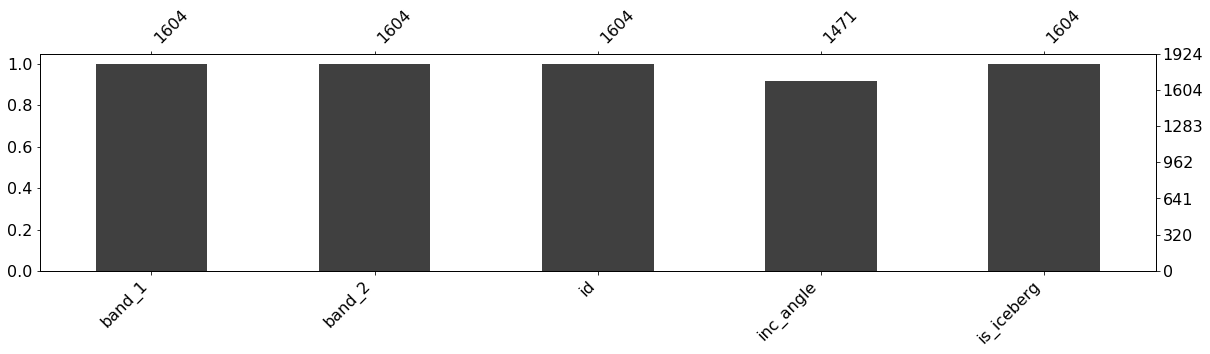

In [13]:
import missingno as msno
msno.bar(data,figsize=(20,4))

### 2.1.2 Data exploration of label
Let's check if the two sets, icebergs and ships, are balanced (Is_iceberg: 753, not_iceberg: 851). 

In [14]:
is_iceberg_1_df = pd.DataFrame(data['is_iceberg'])
Isiceberg=is_iceberg_1_df.sum()
print("Is_iceberg ", Isiceberg)
print("Not_iceberg ", (1604-Isiceberg))

Is_iceberg  is_iceberg    753
dtype: int64
Not_iceberg  is_iceberg    851
dtype: int64


D:\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



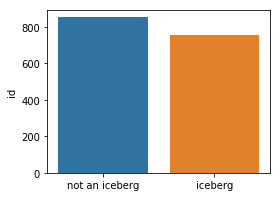

In [15]:
f,ax = plt.subplots(1,1,figsize=(4,3))
sns.barplot(x=['not an iceberg','iceberg'],y=train.groupby(['is_iceberg'],as_index=False).count()['id'])
plt.show()

### 2.1.3 Data exploration of angle 
Here you can see the distribution of the angles at which detections took place. There where null values I turned to 0. It is not look like a normal ditribution

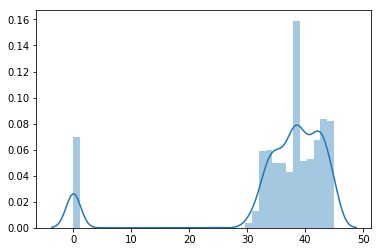

In [16]:
f,ax = plt.subplots(1,1,figsize=(6,4))
angles = [int(float(t)) if t!='na' else 0 for t in train['inc_angle']]
train['intangle'] = angles
sns.distplot(angles)
plt.show()

### 2.1.4 Data exploration of image (Band_1 and Band_2)
The images are 75x75 images with two bands (Band_1: HH/Band_2: HV). I load the data and then combine the two bands and recombine them into a single image/tensor for review.

In [17]:
train_images = train.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
train_images = np.stack(train_images).squeeze()

Based on the below image, the data look like pretty messier and it appears that the background is not realy random noise but rather has some spatial correlations. If the background is dominated by things like waves rather than noise, then spatial correlations would clearly be expected. Besides, the ships seem to have a more regular structure than iceberg, with a pronounced skewness in the blobs for larger signals. Some of these blobs are not that high above noise, so it may be advantageous to first transform the images in some way to enhance the contrast between the signals and the background.

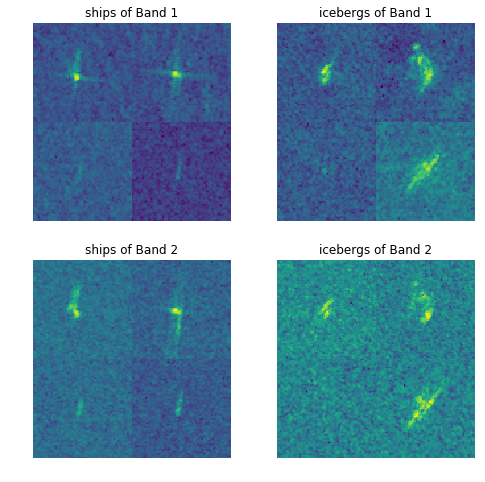

In [18]:
from skimage.util.montage import montage2d
fig, (ax1s, ax2s) = plt.subplots(2,2, figsize = (8,8))
obj_list = dict(ships = train.query('is_iceberg==0').sample(4).index,
     icebergs = train.query('is_iceberg==1').sample(4).index)
for ax1, ax2, (obj_type, idx_list) in zip(ax1s, ax2s, obj_list.items()):
    ax1.imshow(montage2d(train_images[idx_list,:,:,0]))
    ax1.set_title('%s of Band 1' % obj_type)
    ax1.axis('off')
    ax2.imshow(montage2d(train_images[idx_list,:,:,1]))
    ax2.set_title('%s of Band 2' % obj_type)
    ax2.axis('off')

## 2.2 Evaluation Metrics
I use three index to calculate performance of my model: **precision**, **recall**, and **F-score**. The final result will be decided by F-score with β = 0.5.

In [21]:
# Import 4 metrics from sklearn
from sklearn.metrics import precision_score,recall_score,fbeta_score

I can't find the metrics for perfomance calculation from Keras, so I made by myself:

In [22]:
# Performance function
def performance_model(prediction,y_test):
    # Get Label in array
    list = []
    for i in y_test:
        list.append(i)
    
    arr = np.arange(len(y_test)).reshape(len(y_test),1)
    np.place(arr, arr>=0, list)
    
    # TN: True Nagetive, TP: True Positive, FP: False Positive, FN: False Nagetive
    i = 0
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    while i < len(y_test):
        if prediction[i,0] == arr[i,0]:
            if prediction[i,0] == 0:
                TN += 1
            else:
                TP += 1
        else:
            if prediction[i,0] == 1:
                FP += 1
            else:
                FN += 1
        i += 1
        
    #  Accuracy (ACC), precision (PR), recall (RC),and F-score(FS)
    ACC = (TN+TP)/(TN+TP+FP+FN)
    PR = TP/(TP+FP)
    RC = TP/(TP+FN)
    FS = 2*(PR*RC)/(PR+RC)
    
    return(ACC,PR,RC,FS)

## 2.3  Benchmark Model
I choose **Random Forest** as my benchmark model to check if the problem is solvable or not in machine learning. Later, I will compare with final result to see how performance get well after final test.

### 2.3.1 Drop missing data

In [24]:
# Replace the 'na's with numpy.nan
train_drop=train.copy()
train_drop.inc_angle.replace({'na':np.nan}, inplace=True)

# Drop the rows that has NaN value for inc_angle
train.drop(train_drop[train_drop['inc_angle'].isnull()].index,inplace=True)
#train_drop.info()

X_HH_train=np.array([np.array(band).astype(np.float32) for band in train_drop.band_1])
X_HV_train=np.array([np.array(band).astype(np.float32) for band in train_drop.band_2])
X_angle_train=np.array([[np.array(angle).astype(np.float32) for angle in train_drop.inc_angle]]).T
Ytrain=train_drop.is_iceberg.values.astype(np.float32)
Xtrain=np.concatenate((X_HH_train,X_HV_train,X_angle_train), axis=1)
# Now, we have 75*75 numerical features for band_1, 75*75 numerical features for band_2, and 1  feature for angle 
train_drop.shape

(1471, 5)

### 2.3.2 Set up training and test sets

In [25]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the data into training and testing sets with 20% test rate
X_train, X_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1176 samples.
Testing set has 295 samples.


### 2.3.3 Pre-train model
The score (precision/recall/F-score) of first run is 0.7465/0.6839/0.7331. It seems like solvable because the performance is acceptable in the absence of data extraction.

In [25]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=101)
RFC.fit(X_train,y_train)

print ("precision on testing data of RandomForestClassifier: {:.4f}".format(precision_score(y_test, RFC.predict(X_test))))
print ("recall on testing data of RandomForestClassifier: {:.4f}".format(recall_score(y_test, RFC.predict(X_test))))
print ("F-Score on testing data of RandomForestClassifier: {:.4f}".format(fbeta_score(y_test, RFC.predict(X_test), beta = 0.5)))


precision on testing data of RandomForestClassifier: 0.7465
recall on testing data of RandomForestClassifier: 0.6839
F-Score on testing data of RandomForestClassifier: 0.7331


# 3. Methdology

## 3.1  Solution Statement
I will use 4 supervised learning methodology, **Support Vector Machine (SVM)**, **Adaptive Boosting(AdaBoost)**, and **eXtreme Gradient Boosting (XGboost)** with all factors to predict test data. Before doing this, some feature engineering should be done. Then I will use deep learning - **Convolutional Neural Networks (CNN)** to predict test data and compared with previous 4 supervised learning. In CNN, it only can be use imagical factors, so the “angle” will be dropped before model training. Furthermore, CNN model needs three input channels but we only have two (band_1 and band_2) in the datasets. I will take the mean of band_1 and band_2 to be used as the third channel.

## 3.2 Initial Model Evaluation
* Data Pre-process: Dropping the missing data, normalizing numerical features, and transforming skewed continuous features.
* Initial Model Evaluation: Before data engineering, I will properly evaluate the performance of each model (SVM, Adaboost, XGBoost, CNN).
* Feature Extraction: In CNN, the feature can be extracted in convolution process. In other supervised learning (SVM, Adaboost, XGBoost), the feature will be extracted by statistics.
* Model Tuning: To improve performance, I will use GridSearchCV by Scikit-learn to find the optimization parameters in each supervised learning model.
* Data Augmentation: I added more data to train set by simply way including horizontally and vertically flipped data.

Finally, based on the above process, I will evaluate the performance of each model and choose the best as the result of this study.


# 4 Supervised Learning Development

## 4.1 Data Pre-process
As shown in the code, I create a numpy matrix with different matrices which includes all features, which enables us to build different combinations of input variables for the model. Then I use **MaxAbsScaler** to scale each variable in the range of [-1,+1] which is centered by 0, in order to normalizing numerical features

In [16]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler() #MinMaxScaler()
Xtrain_maxabs = scaler.fit_transform(Xtrain)

## 4.2 Initial Model Evaluation
Pre-train model wiht 4 supervised learning - SVM/Adaptive Boosting/eXtreme Gradient Boosting

In [17]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xtrain_maxabs, Ytrain, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1176 samples.
Testing set has 295 samples.


In [18]:
# Import 4 metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,fbeta_score
# Import 3 Classifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

SVM = SVC(random_state = 101)
ABC = AdaBoostClassifier(random_state = 101)
XGB = XGBClassifier(random_state = 101)

SVM.fit(X_train,y_train)
ABC.fit(X_train,y_train)
XGB.fit(X_train,y_train)

accuracy_score,precision_score,recall_score,fbeta_score

print ("precision on testing data of SVM: {:.4f}".format(precision_score(y_test, SVM.predict(X_test))))
print ("precision on testing data of AdaBoostClassifier: {:.4f}".format(precision_score(y_test, ABC.predict(X_test))))
print ("precision on testing data of XGBooster: {:.4f}".format(precision_score(y_test, XGB.predict(X_test))))

print ("recall on testing data of SVM: {:.4f}".format(recall_score(y_test, SVM.predict(X_test))))
print ("recall on testing data of AdaBoostClassifier: {:.4f}".format(recall_score(y_test, ABC.predict(X_test))))
print ("recall on testing data of XGBooster: {:.4f}".format(recall_score(y_test, XGB.predict(X_test))))

print ("F-Score on testing data of SVM: {:.4f}".format(fbeta_score(y_test, SVM.predict(X_test), beta = 0.5)))
print ("F-Score on testing data of AdaBoostClassifier: {:.4f}".format(fbeta_score(y_test, ABC.predict(X_test), beta = 0.5)))
print ("F-Score on testing data of XGBooster: {:.4f}".format(fbeta_score(y_test, XGB.predict(X_test), beta = 0.5)))

precision on testing data of SVM: 0.6096
precision on testing data of AdaBoostClassifier: 0.7558
precision on testing data of XGBooster: 0.7676
recall on testing data of SVM: 0.8968
recall on testing data of AdaBoostClassifier: 0.8387
recall on testing data of XGBooster: 0.9161
F-Score on testing data of SVM: 0.6514
F-Score on testing data of AdaBoostClassifier: 0.7711
F-Score on testing data of XGBooster: 0.7933


### Summary of Pre-train model
Based on F-Score, we can see that Adabooster & XGBooster have a significant improvement after data preprocess compared to benchmark model. But the F-Score of SVM is small than benchmark model (0.6514<0.7331), due to precision is too low (0.6096). I hope in the next step, the performance of SVM will be better after data extraction & model turning.

| KPI | Benchmark Model(RandomForest) | SVM | AdaBooster | XGBooster
| :--: |
| **precision** |  0.7465 | 0.6096 | 0.7558 | 0.7676 |
| **recall** | 0.6839 | 0.8968 | 0.8387| 0.9161 |
| **F-Score** | 0.7331 | 0.6514| 0.7711| 0.7933 |


## 4.3 Feature Extraction
I plan to use SVD(Singular Value Decomposition) to dimensionally reduce the images to just a few features. Before to do this, Let me to check some picture in different mode.

In [26]:
#get numpy arrays for test data of band1&band2
band1 = train_drop['band_1'].values
im1 = np.zeros((len(band1),len(band1[0])))
for j in range(len(band1)):
    im1[j,:]=np.asarray(band1[j])
    
band2 = train_drop['band_2'].values
im2 = np.zeros((len(band2),len(band2[0])))
for j in range(len(band2)):
    im2[j,:]=np.asarray(band2[j])

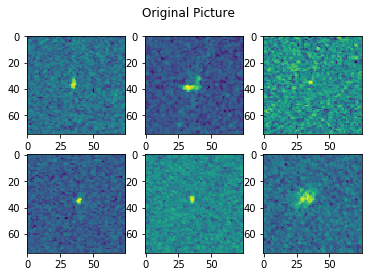

In [27]:
#Orignal Picture

fig, ax = plt.subplots(2,3)
plt.suptitle('Original Picture')
ax[0,0].imshow(np.reshape(im2[0,:],(75,75)))
ax[0,1].imshow(np.reshape(im2[1,:],(75,75)))
ax[0,2].imshow(np.reshape(im2[2,:],(75,75)))
ax[1,0].imshow(np.reshape(im2[3,:],(75,75)))
ax[1,1].imshow(np.reshape(im2[4,:],(75,75)))
ax[1,2].imshow(np.reshape(im2[5,:],(75,75)))

In [28]:
#svd of the two bands
U1,s1,V1 = np.linalg.svd(im1,full_matrices = 0)
U2,s2,V2 = np.linalg.svd(im2,full_matrices = 0)

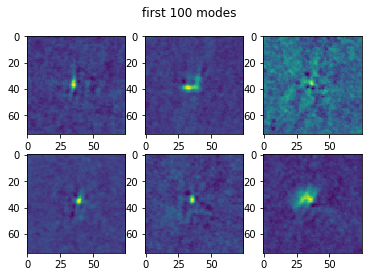

In [29]:
#Let check first 100 modes

nmodes = 100

im1p=np.dot(np.dot(U1[:,:nmodes],np.diag(s1[:nmodes])),V1[:nmodes,])
im2p=np.dot(np.dot(U2[:,:nmodes],np.diag(s2[:nmodes])),V2[:nmodes,])

fig, ax = plt.subplots(2,3)
plt.suptitle('first 100 modes')
ax[0,0].imshow(np.reshape(im2p[0,:],(75,75)))
ax[0,1].imshow(np.reshape(im2p[1,:],(75,75)))
ax[0,2].imshow(np.reshape(im2p[2,:],(75,75)))
ax[1,0].imshow(np.reshape(im2p[3,:],(75,75)))
ax[1,1].imshow(np.reshape(im2p[4,:],(75,75)))
ax[1,2].imshow(np.reshape(im2p[5,:],(75,75)))

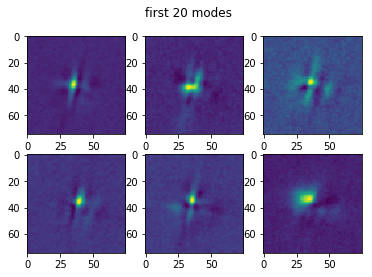

In [30]:
#Let check first 20 modes

nmodes = 20

im1p=np.dot(np.dot(U1[:,:nmodes],np.diag(s1[:nmodes])),V1[:nmodes,])
im2p=np.dot(np.dot(U2[:,:nmodes],np.diag(s2[:nmodes])),V2[:nmodes,])

fig, ax = plt.subplots(2,3)

plt.suptitle('first 20 modes')
ax[0,0].imshow(np.reshape(im2p[0,:],(75,75)))

ax[0,1].imshow(np.reshape(im2p[1,:],(75,75)))
ax[0,2].imshow(np.reshape(im2p[2,:],(75,75)))
ax[1,0].imshow(np.reshape(im2p[3,:],(75,75)))
ax[1,1].imshow(np.reshape(im2p[4,:],(75,75)))
ax[1,2].imshow(np.reshape(im2p[5,:],(75,75)))

First 20 modes (20 numbers per image) have most of useful information, 
as most of variance is just noise. Let's run with supervised learning.

In [31]:
nmodes = 20
X = np.hstack((U1[:,:nmodes],U2[:,:nmodes]))
y = train_drop['is_iceberg'].values

In [24]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# test with SVM/ABC/XGB after data extraction
SVM.fit(X_train,y_train)
ABC.fit(X_train,y_train)
XGB.fit(X_train,y_train)

print ("precision on testing data of SVM: {:.4f}".format(precision_score(y_test, SVM.predict(X_test))))
print ("precision on testing data of AdaBoostClassifier: {:.4f}".format(precision_score(y_test, ABC.predict(X_test))))
print ("precision on testing data of XGBooster: {:.4f}".format(precision_score(y_test, XGB.predict(X_test))))

print ("recall on testing data of SVM: {:.4f}".format(recall_score(y_test, SVM.predict(X_test))))
print ("recall on testing data of AdaBoostClassifier: {:.4f}".format(recall_score(y_test, ABC.predict(X_test))))
print ("recall on testing data of XGBooster: {:.4f}".format(recall_score(y_test, XGB.predict(X_test))))

print ("F-Score on testing data of SVM: {:.4f}".format(fbeta_score(y_test, SVM.predict(X_test), beta = 0.5)))
print ("F-Score on testing data of AdaBoostClassifier: {:.4f}".format(fbeta_score(y_test, ABC.predict(X_test), beta = 0.5)))
print ("F-Score on testing data of XGBooster: {:.4f}".format(fbeta_score(y_test, XGB.predict(X_test), beta = 0.5)))

precision on testing data of SVM: 0.5254
precision on testing data of AdaBoostClassifier: 0.7738
precision on testing data of XGBooster: 0.8011
recall on testing data of SVM: 1.0000
recall on testing data of AdaBoostClassifier: 0.8387
recall on testing data of XGBooster: 0.9355
F-Score on testing data of SVM: 0.5805
F-Score on testing data of AdaBoostClassifier: 0.7860
F-Score on testing data of XGBooster: 0.8248


### Performance Summary of Feature Extraction
We can see that XGBooster has the best performance after feature extraction, the F-Score has been improve to 0.8248 from 0.7933. Adabooster is the second, the F-Score has been improve to 0.7860 from 0.7711. Besides, SVM does not perform well, the F-Score has been decreasd to 0.5805 from 0.6514 due to precision is too low (0.5254). Maybe the parameters have not been optimized in SVM(The default parameters are not suitable here), I hope the performance will be better after model turning.

* F-Score

| Methdology | Benchmark Model | Data Preprocess | Feature Extraction |
| :--: |
| SVM | 0.7331 | 0.6514| 0.5805 |
| AdaBooster | 0.7331 | 0.7711| 0.7860 |
| XGBooster | 0.7331 | 0.7933 | 0.8248 |   

* Precision

| Methdology | Benchmark Model | Data Preprocess | Feature Extraction |
| :--: |
| SVM | 0.7465 | 0.6096 | 0.5254 |
| AdaBooster |  0.7465 | 0.7558 | 0.7738 |
| XGBooster |  0.7465 | 0.7676 | 0.8011 |

* Recall

| Methdology | Benchmark Model | Data Preprocess | Feature Extraction |
| :--: |
| SVM | 0.6839 | 0.8968 | 1.0000 |
| AdaBooster | 0.6839 | 0.8387 | 0.8387 |
| XGBooster | 0.6839 | 0.9161 | 0.9355 |

## 4.4 Model Tuning (Optimized Model)
In this section, I use **GridSearchCV** to optimize the classifier by cross-validation.
The performance of the selected hyper-parameters and trained model measured on a  data set after data extraction.

In [25]:
## import GridSearchCV from sklearn
from sklearn.grid_search import GridSearchCV

D:\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [26]:
## import classifier
# from sklearn.metrics import make_scorer


#SVM = svm.SVC(kernel='rbf',probability=False)
SVM = SVC(random_state = 101)
ABC = AdaBoostClassifier(random_state = 101)
XGB = XGBClassifier(random_state = 101)

# Set the range of hyper-parameter we wanna use to tune our classifier
# SVM
C_range = [0.1,1,10,50,100] #10
gamma_range = [0,5,10,20,50] #100 ***
param_grid_SVM = dict(gamma=gamma_range, C=C_range)
# AdaBoost
parameters_ABC = {'n_estimators':[10, 50, 100, 200, 1000], #1000 ***
              'learning_rate' : [0.2,0.4,0.6,0.8,1.0], #0.2
             }
#XGBooster
parameters_XGB = {'learning_rate': [0.2,0.4,0.6,0.8,1.0],  #0.2
                  'max_depth': [6,10,20,50,100], #10 ***
                  'gamma': [0,5,10,20,50]} #0

# set the gridsearch using 3-fold cross validation and 'ROC Area Under the Curve' as the cross validation score.
# SVM
grid_SVM = GridSearchCV(SVM, param_grid=param_grid_SVM, cv=3,scoring='roc_auc')
grid_SVM_fit=grid_SVM.fit(X_train,y_train)
# AdaBoost
grid_ABC = GridSearchCV(ABC, parameters_ABC,scoring='roc_auc')
grid_ABC_fit = grid_ABC.fit(X_train,y_train)
# XGBoost
grid_XGB = GridSearchCV(XGB, parameters_XGB,scoring='roc_auc')
grid_XGB_fit = grid_XGB.fit(X_train,y_train)

# Get the estimator
best_clf_SVM = grid_SVM_fit.best_estimator_
best_clf_ABC = grid_ABC_fit.best_estimator_
best_clf_XGB = grid_XGB_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions_SVM = (SVM.fit(X_train, y_train)).predict(X_test)
best_predictions_SVM = best_clf_SVM.predict(X_test)
predictions_ABC = (ABC.fit(X_train, y_train)).predict(X_test)
best_predictions_ABC = best_clf_ABC.predict(X_test)
predictions_XGB = (XGB.fit(X_train, y_train)).predict(X_test)
best_predictions_XGB = best_clf_XGB.predict(X_test)

print ("After GridSearchCV, precision score of SVM: {:.4f}".format(precision_score(y_test, best_predictions_SVM)))
print ("After GridSearchCV, precision score of AdaBoost: {:.4f}".format(precision_score(y_test, best_predictions_ABC)))
print ("After GridSearchCV, precision score of XGBoost: {:.4f}".format(precision_score(y_test, best_predictions_XGB)))

print ("After GridSearchCV, recall score of SVM: {:.4f}".format(recall_score(y_test, best_predictions_SVM)))
print ("After GridSearchCV, recall score of AdaBoost: {:.4f}".format(recall_score(y_test, best_predictions_ABC)))
print ("After GridSearchCV, recall score of XGBoost: {:.4f}".format(recall_score(y_test, best_predictions_XGB)))

print ("After GridSearchCV, F-score on SVM: {:.4f}".format(fbeta_score(y_test, best_predictions_SVM, beta = 0.5)))
print ("After GridSearchCV, F-score on AdaBoost: {:.4f}".format(fbeta_score(y_test, best_predictions_ABC, beta = 0.5)))
print ("After GridSearchCV, F-score on XGBoost: {:.4f}".format(fbeta_score(y_test, best_predictions_XGB, beta = 0.5)))

After GridSearchCV, precision score of SVM: 0.8284
After GridSearchCV, precision score of AdaBoost: 0.7953
After GridSearchCV, precision score of XGBoost: 0.8324
After GridSearchCV, recall score of SVM: 0.9032
After GridSearchCV, recall score of AdaBoost: 0.8774
After GridSearchCV, recall score of XGBoost: 0.9290
After GridSearchCV, F-score on SVM: 0.8424
After GridSearchCV, F-score on AdaBoost: 0.8105
After GridSearchCV, F-score on XGBoost: 0.8501


## 4.5 Spervised Learning Summary
It is exciting that see the performance is pretty well after data preprocess, feature extraciton, and model tuning. No matter what classifier, It has been improve so much. The final F-score of SVM/Adabooster/XGBooster is 0.8424/0.8105/0.8501 with 29%/5%/7% improvement. The best classifier is **XGBooster** (**F-score: 0.8501**) of all supervised learning in my test. In the next chapter, I plan to develop convolutional neural networks (CNN) to see how good is in computer vision problem.

* F-Score

| Methodology | Benchmark Model | Data Preprocess | Feature Extraction | Optimized Model |
| :--: |
| SVM | 0.7331 | 0.6514| 0.5805 | 0.8424
| AdaBooster | 0.7331 | 0.7711| 0.7860 | 0.8105
| XGBooster | 0.7331 | 0.7933 | 0.8248 | **0.8501**

* Precision

| Methodology | Benchmark Model | Data Preprocess | Feature Extraction | Optimized Model |
| :--: |
| SVM | 0.7465 | 0.6096 | 0.5254 | 0.8284
| AdaBooster |  0.7465 | 0.7558 | 0.7738 | 0.7953
| XGBooster |  0.7465 | 0.7676 | 0.8011 | 0.8324

* Recall

| Methodology | Benchmark Model | Data Preprocess | Feature Extraction | Optimized Model |
| :--: |
| SVM | 0.6839 | 0.8968 | 1.0000 | 0.9032
| AdaBooster | 0.6839 | 0.8387 | 0.8387 | 0.8774
| XGBooster | 0.6839 | 0.9161 | 0.9355 | 0.9290

# 5. Deep Learning Development

## 5.1 Signal Review
The picture as below illustrate the typical SAR signature of an iceberg and a ship in an C Band high resolution image. The high resolution of Sentinet -1 StripMap mode allows the detection of structural components from both floating structures. Even though ships and icebergs can have similar intensity and size values, their structures and shapes typically follow different patterns. The CNN is designed to learn a set of features from the input image in a supervised training process, in a way to capture the differences between the two observed classes, include of shapes and structures. That is the advantage that traditional supervised learning doesn’t have.

In [34]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])

In [35]:
print(X_band_1[12,:,:])

[[-21.112206 -21.638832 -25.436468 ... -21.642082 -20.946886 -18.876122]
 [-20.146112 -21.638832 -23.222504 ... -18.876074 -17.537186 -17.765821]
 [-18.87273  -20.77814  -22.008549 ... -20.4597   -19.703976 -20.459793]
 ...
 [-23.900232 -24.894037 -23.008686 ... -22.802628 -29.692589 -20.782188]
 [-24.382906 -25.161316 -24.894083 ... -23.90358  -25.440426 -24.63813 ]
 [-24.138218 -23.668642 -23.44307  ... -22.802628 -25.440426 -24.141657]]


In [36]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=10,
            b=15,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

In [37]:
plotmy3d(X_band_1[14,:,:], 'Ship')

## 5.2 Data Pre-process
In this section, I user **Max-min scaler** to nomalize data: **(x-mean)/(Max-Min)**. Furthermore, CNN model needs three input channels but we only have two (band_1 and band_2) in the datasets. I will take **the mean** of band_1 and band_2 to be used as the third channel.

In [27]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = (band_1 + band_2)/2
        # Normalize
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [28]:
Xtrain_CNN = get_scaled_imgs(train)
Ytrain_CNN = np.array(train['is_iceberg'])

## 5.3 Initial Model Evaluation

In [29]:
# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


In [30]:
# Define CNN Model
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

Now we get the model and ready to train

In [31]:
model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [32]:
# Split the 'features' and 'income' data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain_CNN, Ytrain_CNN, random_state=1, train_size=0.80)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1176 samples.
Testing set has 295 samples.


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [56]:
train_hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

Train on 882 samples, validate on 294 samples
Epoch 1/20
882/882 [==============================] - 62s 71ms/step - loss: 0.6806 - acc: 0.5703 - val_loss: 0.6512 - val_acc: 0.7517
Epoch 2/20
882/882 [==============================] - 62s 71ms/step - loss: 0.5619 - acc: 0.7166 - val_loss: 0.4531 - val_acc: 0.7959
Epoch 3/20
882/882 [==============================] - 58s 65ms/step - loss: 0.4752 - acc: 0.7744 - val_loss: 0.4405 - val_acc: 0.8435
Epoch 4/20
882/882 [==============================] - 62s 70ms/step - loss: 0.4021 - acc: 0.8118 - val_loss: 0.3537 - val_acc: 0.8367
Epoch 5/20
882/882 [==============================] - 61s 69ms/step - loss: 0.4385 - acc: 0.7778 - val_loss: 0.3762 - val_acc: 0.8333
Epoch 6/20
882/882 [==============================] - 50s 57ms/step - loss: 0.3561 - acc: 0.8390 - val_loss: 0.2994 - val_acc: 0.8844
Epoch 7/20
882/882 [==============================] - 54s 61ms/step - loss: 0.3808 - acc: 0.8254 - val_loss: 0.3346 - val_acc: 0.8469
Epoch 8/20
882/8

In [57]:
prediction = model.predict_classes(X_test)

#### Initial Model of CNN Result
We can see that the **F-score** of CNN is **0.9172**. That is better than below supervised model. In the next section, I used data augmentation to increase datasets and expect to have better performance than initial model.

In [58]:
#X_train, X_test, y_train, y_test
ACC,PR,RC,FS = performance_model(prediction,y_test)
print('Accuracy: ',ACC)
print('Precision:',PR)
print('Recall: ',RC)
print('F-score: ',FS)

Accuracy:  0.9186440677966101
Precision: 0.9708029197080292
Recall:  0.869281045751634
F-score:  0.9172413793103448


## 5.4 Data Augmentation
For performance improvement, I added more data to train set by simply way including horizontally and vertically flipped data.

In [25]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [26]:
Xtrain_more = get_more_images(Xtrain_CNN) 
Ytrain_more = np.concatenate((Ytrain_CNN,Ytrain_CNN,Ytrain_CNN))

## 5.5 Final test of CNN

In [30]:
model2 = getModel()
model2.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [31]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xtrain_more, Ytrain_more, random_state=1, train_size=0.80)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training set has 1176 samples.
Testing set has 295 samples.


In [32]:
train_hist2 = model2.fit(X_train2, y_train2, batch_size=batch_size, epochs=20, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

Train on 2647 samples, validate on 883 samples
Epoch 1/20
2647/2647 [==============================] - 139s 53ms/step - loss: 0.6395 - acc: 0.6011 - val_loss: 0.5273 - val_acc: 0.7724
Epoch 2/20
2647/2647 [==============================] - 139s 53ms/step - loss: 0.4236 - acc: 0.8073 - val_loss: 0.3648 - val_acc: 0.8482
Epoch 3/20
2647/2647 [==============================] - 143s 54ms/step - loss: 0.3183 - acc: 0.8625 - val_loss: 0.2936 - val_acc: 0.8811
Epoch 4/20
2647/2647 [==============================] - 148s 56ms/step - loss: 0.2996 - acc: 0.8723 - val_loss: 0.3068 - val_acc: 0.8698
Epoch 5/20
2647/2647 [==============================] - 156s 59ms/step - loss: 0.2723 - acc: 0.8946 - val_loss: 0.2844 - val_acc: 0.8890
Epoch 6/20
2647/2647 [==============================] - 146s 55ms/step - loss: 0.2344 - acc: 0.9090 - val_loss: 0.2676 - val_acc: 0.8890
Epoch 7/20
2647/2647 [==============================] - 98s 37ms/step - loss: 0.2090 - acc: 0.9192 - val_loss: 0.3069 - val_acc: 0.

In [33]:
prediction2 = model2.predict_classes(X_test2)

In [34]:
#X_train, X_test, y_train, y_test
ACC,PR,RC,FS = performance_model(prediction2,y_test2)
print('Accuracy: ',ACC)
print('Precision:',PR)
print('Recall: ',RC)
print('F-score: ',FS)

Accuracy:  0.9263873159682899
Precision: 0.9235668789808917
Recall:  0.9375
F-score:  0.9304812834224598


## Deep Learning Summary
We can see that while the **Precision** has been decreased from 0.9708 to 0.9235, but the **Recall** has been increased from 0.8692 to 0.9375 and let **F-scorer** improve 1.4% (0.9172 to **0.9304**).

| KPI | Benchmark Model(RandomForest) | Initial Model  | Data Augmentation |
| :--: |
| Precision | 0.7465 | 0.9708 | 0.9235 |
| Recall | 0.6839 | 0.8692 | 0.9375 |
| F-scorer | 0.7331 | 0.9172 | **0.9304** |

# 6. Result
Compare with 4 methodologies, beyond all doubt, the CNN model is the best classifier in the Iceberg classification problem, even that the CNN performance in initial model (0.9172) is good than all of final supervised learning model (around 0.81~0.85). The final test show that the F-score of CNN is 0.9304, this is higher than what I expected.


| Methodology | Benchmark Model | Data Preprocess | Data Extraction | Data Augmentation/Optimized Model |
| :--: |
| SVM | 0.7331 | 0.6514| 0.5805 | **0.8424** |
| AdaBooster | 0.7331 | 0.7711| 0.7860 | **0.8105** |
| XGBooster | 0.7331 | 0.7933 | 0.8248 | **0.8501** |
| CNN | 0.7331 | 0.9172 | 0.9172 | **0.9304** |

# 7. Conclusion
In this study, we successfully used data extraction & GridSearchCV to improve the 3 supervised learning (SVM/AdaBooster/XGBooster) performances. In the part of CNN, with the data pre-process and the data augmentation, the F-score improved by 2%. From this study, the CNN is still a more applicable method for image classification problems. The reason is that the CNN is able to learn relevant features from the input image, resulting in a better generalized model, which is better than other machine learning methods.
Although CNNs have achieved great success in experimental evaluations, there are still lots of issues that deserve further investigation. Firstly, since the recent CNNs are becoming deeper and deeper, they require large-scale dataset and massive computing power for training. Manually collecting labeled dataset requires huge amounts of human efforts. Thus, it is the next topic that how to explore unsupervised learning of CNNs. 
Furthermore, one major barrier for applying CNN on a new task is that it requires considerable skill and experience to select suitable hyper-parameters such as the learning rate, kernel sizes of convolutional filters, the number of layers etc. These hyper-parameters have internal dependencies which make them particularly expensive for tuning. It is also a challenge of next study.

In [42]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score,GridSearchCV

In [61]:
XGB = XGBClassifier(random_state = 101)
learning_rate_R = [0.2,0.4,0.6,0.8,1.0]
max_depth_R = [6,10,20,50,100]
param_grid_XGB = dict(learning_rate=learning_rate_R,max_depth=max_depth_R)
grid = GridSearchCV(XGB, param_grid_XGB,scoring='roc_auc')
grid_fit = grid.fit(X_train,y_train)

In [63]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Visualization analysis 
As below plot is a heatmap of the XGBooster’s cross-validation accuracy score as a function of learning rate and gamma. For this example we explore a relatively grid for illustration purposes. The behavior of the model is very sensitive to the parameter of max_depth (the maximum depth of a tree). If max_depth is too large, it will make the model more complex and likely to be overfitting. Limit of max_depth is required for depth-wise grow policy

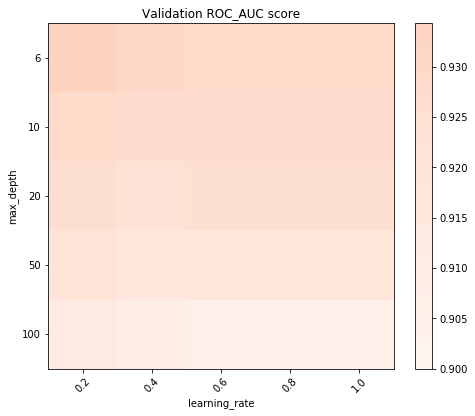

In [75]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
scores = grid.cv_results_['mean_test_score'].reshape(len(learning_rate_R),len(max_depth_R))
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,norm=MidpointNormalize(vmin=0.9, midpoint=1))
plt.imshow(scores, interpolation='nearest', cmap='Reds',norm=MidpointNormalize(vmin=0.9, midpoint=1))
plt.xlabel('learning_rate')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(learning_rate_R)), learning_rate_R, rotation=45)
plt.yticks(np.arange(len(max_depth_R)), max_depth_R)
plt.title('Validation ROC_AUC score')
plt.show()